In [ ]:
import argparse
import copy
import math
import sys
import os
import h5py
import multiprocessing
from multiprocessing import Pool
import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
#from tensorboardX import SummaryWriter
import flows as fnn
#import utils as futils
import matplotlib.pyplot as plt


ncpu = multiprocessing.cpu_count()

In [ ]:
import pandas as pd
mydata = pd.read_csv('/content/CMC_data.dat')


In [ ]:
column_names = [
    "model_num", "rv", "rg", "Z", "N", "merger_time(Myr)",
    "id1", "id2", "m1", "m2", "merger_channel"
]

mydata = pd.read_csv('/content/CMC_data.dat', delimiter="\s+", comment="#", names=column_names)

input_columns = ['rv', 'rg', 'Z', 'N']
#rv: varial radius (radius of the cluster)
# rg : posiion of the cluster in the galaxy
#Z: metallicity
#N: number of particles in the cluster

output_columns = ['m1', 'm2', "merger_time(Myr)", "merger_channel"]
#masses of the two black hole
#merger time - how much time from the formation of cluster till they merge
#merger channel - the wave through which these black holes merge

hyperparams_trainvalid = mydata[input_columns].values
data_trainvalid  = mydata[output_columns].values


In [ ]:
data_trainvalid[:,[0,1]]=np.log10(data_trainvalid[:,[0,1]])/100
data_trainvalid[:,2]=np.log10(data_trainvalid[:,2])
data_trainvalid[:,3]=np.log2(data_trainvalid[:,3])


hyperparams_trainvalid[:,0]=hyperparams_trainvalid[:,0]/2
hyperparams_trainvalid[:,1]=hyperparams_trainvalid[:,1]/20
hyperparams_trainvalid[:,2]=np.log10(hyperparams_trainvalid[:,2]/0.02)
hyperparams_trainvalid[:,3]=np.log2(hyperparams_trainvalid[:,3])

In [ ]:
hyperparams_trainvalid

array([[ 0.25,  1.  ,  0.  ,  4.  ],
       [ 0.25,  1.  ,  0.  ,  4.  ],
       [ 0.25,  1.  ,  0.  ,  4.  ],
       ...,
       [ 1.  ,  0.1 , -1.  ,  3.  ],
       [ 1.  ,  0.1 , -1.  ,  3.  ],
       [ 1.  ,  0.1 , -1.  ,  3.  ]])

In [ ]:

class Args:
    def __init__(self):
        self.batch_size = 10**3
        self.test_batch_size = 10**3
        self.epochs = 10 #can track how loss affects
        self.lr = 1e-4
        self.flow = 'maf'
        self.no_cuda = False
        self.cond = True
        self.num_blocks = 10 #number of layers
        self.seed = 1
        self.log_interval = 1000
        self.num_inputs = 4
        self.act = 'relu'
        self.num_hidden = 256 #can play with this, increasing
        self.num_cond_inputs = 4

args = Args()

# Check if CUDA (GPU) is available and set the device accordingly
args.cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if args.cuda else "cpu")



if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of available GPUs: {device_count}")
    for i in range(device_count):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
else:
    print("No GPUs available.")

# Define data loading workers for PyTorch DataLoader
kwargs = {'num_workers': 4, 'pin_memory': True} if args.cuda else {}




No GPUs available.


In [ ]:
# Create a custom PyTorch Dataset class
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, input_data, output_data, input_dtype=torch.float32, output_dtype=torch.float32):
        self.input_data = torch.tensor(input_data, dtype=input_dtype)
        self.output_data = torch.tensor(output_data, dtype=output_dtype)

    def __getitem__(self, index):
        input_sample = self.input_data[index]
        output_sample = self.output_data[index]
        return input_sample, output_sample

    def __len__(self):
        return len(self.input_data)

    @property
    def tensors(self):
        return (self.input_data, self.output_data)


In [ ]:
def train(epoch, model, train_loader):
    global global_step
    model.train()
    train_loss = 0

    pbar = tqdm.tqdm(total=len(train_loader.dataset))

    for batch_idx, data in enumerate(train_loader):
        if isinstance(data, list):
            if len(data) > 1:
                cond_data = data[1].float()
                cond_data = cond_data.to(device)
            else:
                cond_data = None

            data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        loss = -model.log_probs(data, cond_data).mean()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        pbar.update(data.size(0))
        pbar.set_description('Train, Log likelihood in nats: {:.6f}'.format(
            -train_loss / (batch_idx + 1)))
        global_step += 1

    pbar.close()

    for module in model.modules():
        if isinstance(module, fnn.BatchNormFlow):
            module.momentum = 0

    if args.cond:
        with torch.no_grad():
            model(train_loader.dataset.dataset.tensors[0].to(data.device),
                train_loader.dataset.dataset.tensors[1].to(data.device).float())
    else:
        with torch.no_grad():
            model(train_loader.dataset.dataset.tensors[0].to(data.device))


    for module in model.modules():
        if isinstance(module, fnn.BatchNormFlow):
            module.momentum = 1

def validate(epoch, model, loader, prefix='Validation'):
    global global_step, writer

    model.eval()
    val_loss = 0

    pbar = tqdm.tqdm(total=len(loader.dataset))

    pbar.set_description('Eval')
    for batch_idx, data in enumerate(loader):
        if isinstance(data, list):
            if len(data) > 1:
                cond_data = data[1].float()
                cond_data = cond_data.to(device)
            else:
                cond_data = None

            data = data[0]
        data = data.to(device)
        with torch.no_grad():
            val_loss += -model.log_probs(data, cond_data).sum().item()  # sum up batch loss
        pbar.update(data.size(0))


    pbar.close()
    return val_loss / len(loader.dataset)

In [ ]:


modules = []
for _ in range(args.num_blocks):
    modules += [
        fnn.MADE(args.num_inputs, args.num_hidden, args.num_cond_inputs, act=args.act),
        fnn.BatchNormFlow(args.num_inputs),
        fnn.Reverse(args.num_inputs)
    ]
model = fnn.FlowSequential(*modules)

# Initialize the weights and biases of linear layers
for module in model.modules():
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)



In [ ]:
# Generate a timestamp for logging
import datetime
timestamp = datetime.datetime.now().strftime("%b%d_%H-%M-%S")
logdir = f"./Data/logs"
#writer = SummaryWriter(logdir, comment=args.flow)


In [ ]:
#inputs/given condition: 1)rv, 2) rg, 3)Z, 4) N
#outputs: merger_time, m1, m2, merger_channel
#ignore: 0) model_num, 6) id1, 7) id2

In [ ]:
mydata

,model_num,rv,rg,Z,N,merger_time(Myr),id1,id2,m1,m2,merger_channel
0,36,0.5,20.0,0.020,16.0,292.224242,1834592.0,2041552.0,14.100000,13.700000,5
1,36,0.5,20.0,0.020,16.0,361.244899,1755061.0,1376500.0,14.800000,8.060000,5
2,36,0.5,20.0,0.020,16.0,380.915556,841575.0,2378898.0,8.100000,7.340000,5
3,36,0.5,20.0,0.020,16.0,578.985985,1454823.0,1614161.0,8.090000,8.260000,5
4,36,0.5,20.0,0.020,16.0,767.393557,335263.0,1110530.0,7.690000,8.170000,5
...,...,...,...,...,...,...,...,...,...,...,...
12902,79,2.0,2.0,0.002,8.0,2762.273434,695653.0,974142.0,20.148504,20.068989,1
12903,79,2.0,2.0,0.002,8.0,4489.273094,371012.0,461588.0,22.968067,15.378122,1
12904,79,2.0,2.0,0.002,8.0,3075.959306,360550.0,810826.0,17.155740,16.942399,1
12905,79,2.0,2.0,0.002,8.0,6930.893032,524685.0,631994.0,15.808002,15.244599,1


In [ ]:
# Create a PyTorch dataset and split it into training and validation sets
dataset = MyDataset(data_trainvalid, hyperparams_trainvalid)
train_ratio = 0.8

train_size = int(train_ratio * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=args.test_batch_size, shuffle=False, **kwargs)



In [ ]:

global_step = 0

best_validation_loss = float('inf')
best_validation_epoch = 0
best_validation_run = 0
best_model = model

model.to(device)
optimizer = optim.Adadelta(model.parameters())



In [ ]:
# Training loop
for epoch in range(1, args.epochs):
    train(epoch, model, train_loader)
    validation_loss = validate(epoch, model, valid_loader)

    if validation_loss < best_validation_loss:
        best_validation_epoch = epoch
        best_validation_loss = validation_loss
        best_model = copy.deepcopy(model)

    print('Best validation at epoch {}: Average Log Likelihood in nats: {:.4f}'.format(best_validation_epoch, -best_validation_loss))

    if (epoch) - (best_validation_epoch) >= 30:
        break



Train, Log likelihood in nats: 11.102100: 100%|██████████| 10325/10325 [00:02<00:00, 5025.29it/s]

Eval: 100%|██████████| 2582/2582 [00:00<00:00, 18275.37it/s]


Best validation at epoch 1: Average Log Likelihood in nats: 11.0710



Train, Log likelihood in nats: 11.204076: 100%|██████████| 10325/10325 [00:01<00:00, 6434.39it/s]

Eval: 100%|██████████| 2582/2582 [00:00<00:00, 16820.32it/s]


Best validation at epoch 1: Average Log Likelihood in nats: 11.0710



Train, Log likelihood in nats: 11.039568: 100%|██████████| 10325/10325 [00:01<00:00, 5841.73it/s]

Eval: 100%|██████████| 2582/2582 [00:00<00:00, 16624.16it/s]


Best validation at epoch 3: Average Log Likelihood in nats: 11.3297



Train, Log likelihood in nats: 11.239543: 100%|██████████| 10325/10325 [00:02<00:00, 3865.46it/s]

Eval: 100%|██████████| 2582/2582 [00:00<00:00, 19876.72it/s]


Best validation at epoch 3: Average Log Likelihood in nats: 11.3297



Train, Log likelihood in nats: 11.157389: 100%|██████████| 10325/10325 [00:01<00:00, 6510.22it/s]

Eval: 100%|██████████| 2582/2582 [00:00<00:00, 17662.07it/s]


Best validation at epoch 3: Average Log Likelihood in nats: 11.3297



Train, Log likelihood in nats: 11.217931: 100%|██████████| 10325/10325 [00:01<00:00, 5824.19it/s]

Eval: 100%|██████████| 2582/2582 [00:00<00:00, 17134.15it/s]


Best validation at epoch 3: Average Log Likelihood in nats: 11.3297



Train, Log likelihood in nats: 11.178790: 100%|██████████| 10325/10325 [00:01<00:00, 6259.79it/s]

Eval: 100%|██████████| 2582/2582 [00:00<00:00, 17641.50it/s]


Best validation at epoch 3: Average Log Likelihood in nats: 11.3297



Train, Log likelihood in nats: 11.327659: 100%|██████████| 10325/10325 [00:01<00:00, 5787.08it/s]

Eval: 100%|██████████| 2582/2582 [00:00<00:00, 10476.11it/s]


Best validation at epoch 3: Average Log Likelihood in nats: 11.3297



Train, Log likelihood in nats: 11.309221: 100%|██████████| 10325/10325 [00:02<00:00, 4488.67it/s]

Eval: 100%|██████████| 2582/2582 [00:00<00:00, 14626.02it/s]


Best validation at epoch 9: Average Log Likelihood in nats: 11.5637


In [ ]:

maxnum =0.0
current = 0.0;
optimal = 0.0;



for i in range(1,3):
   # Training loop
  for epoch in range(i):
    train(epoch, model, train_loader)
    validation_loss = validate(epoch, model, valid_loader)

    if validation_loss < best_validation_loss:
        best_validation_epoch = epoch
        best_validation_loss = validation_loss
        best_model = copy.deepcopy(model)
        current = best_validation_loss
    if (epoch) - (best_validation_epoch) >= 30:
      break


  if current>maxnum:
    maxnum = current
    optimal = i;


  print("next i")



print(maxnum)
print(optimal)



In [ ]:
#possible values of conditions
np.unique(hyperparams_trainvalid, axis=0)

In [ ]:
hyperparam=[0.5, 1. , 0. , 5. ]
batch_size = 10**4
fixed_noise = torch.Tensor(batch_size, best_model.num_inputs ).normal_()
cond_data=torch.tensor(hyperparam, dtype=torch.float32)

In [ ]:
%%time

best_model.eval()
imgs = best_model.sample(batch_size, noise=fixed_noise, cond_inputs=cond_data).detach().cpu()
imgs=imgs[~torch.isnan(imgs).any(dim=1)]


CPU times: user 170 ms, sys: 75.8 ms, total: 246 ms
Wall time: 257 ms


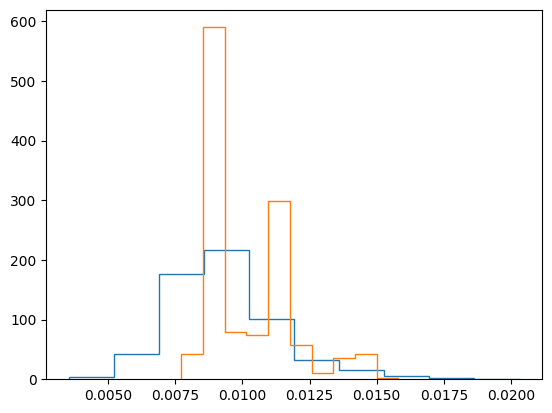

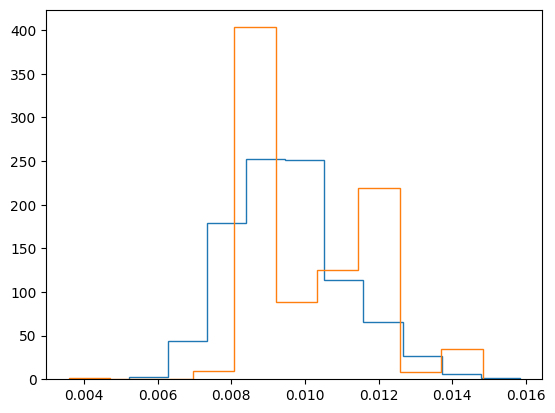

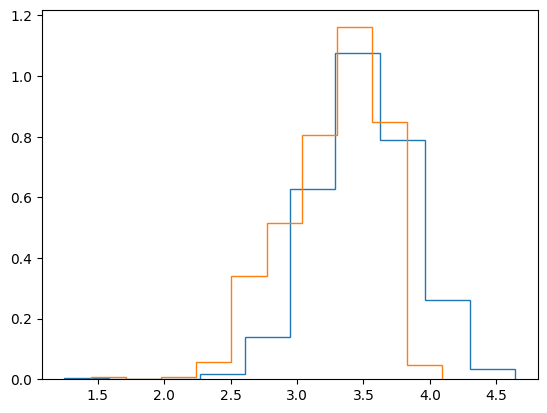

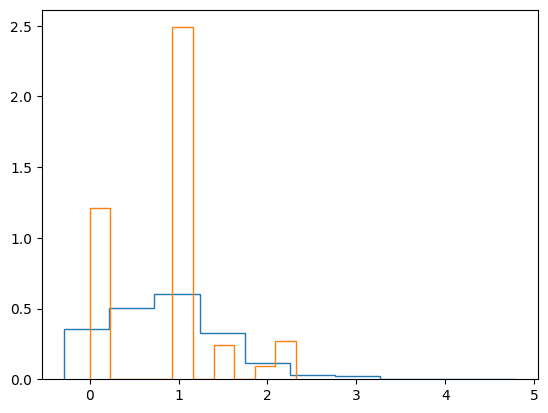

In [ ]:
matching_pos=np.where(np.all(hyperparams_trainvalid == hyperparam, axis=1))[0]
data_selected=data_trainvalid[matching_pos]

for i in range(0,4):
  plt.hist(imgs[:,i].detach().numpy(), histtype='step', density=True)
  plt.hist(data_selected[:,i], histtype='step', density=True)
  plt.show()

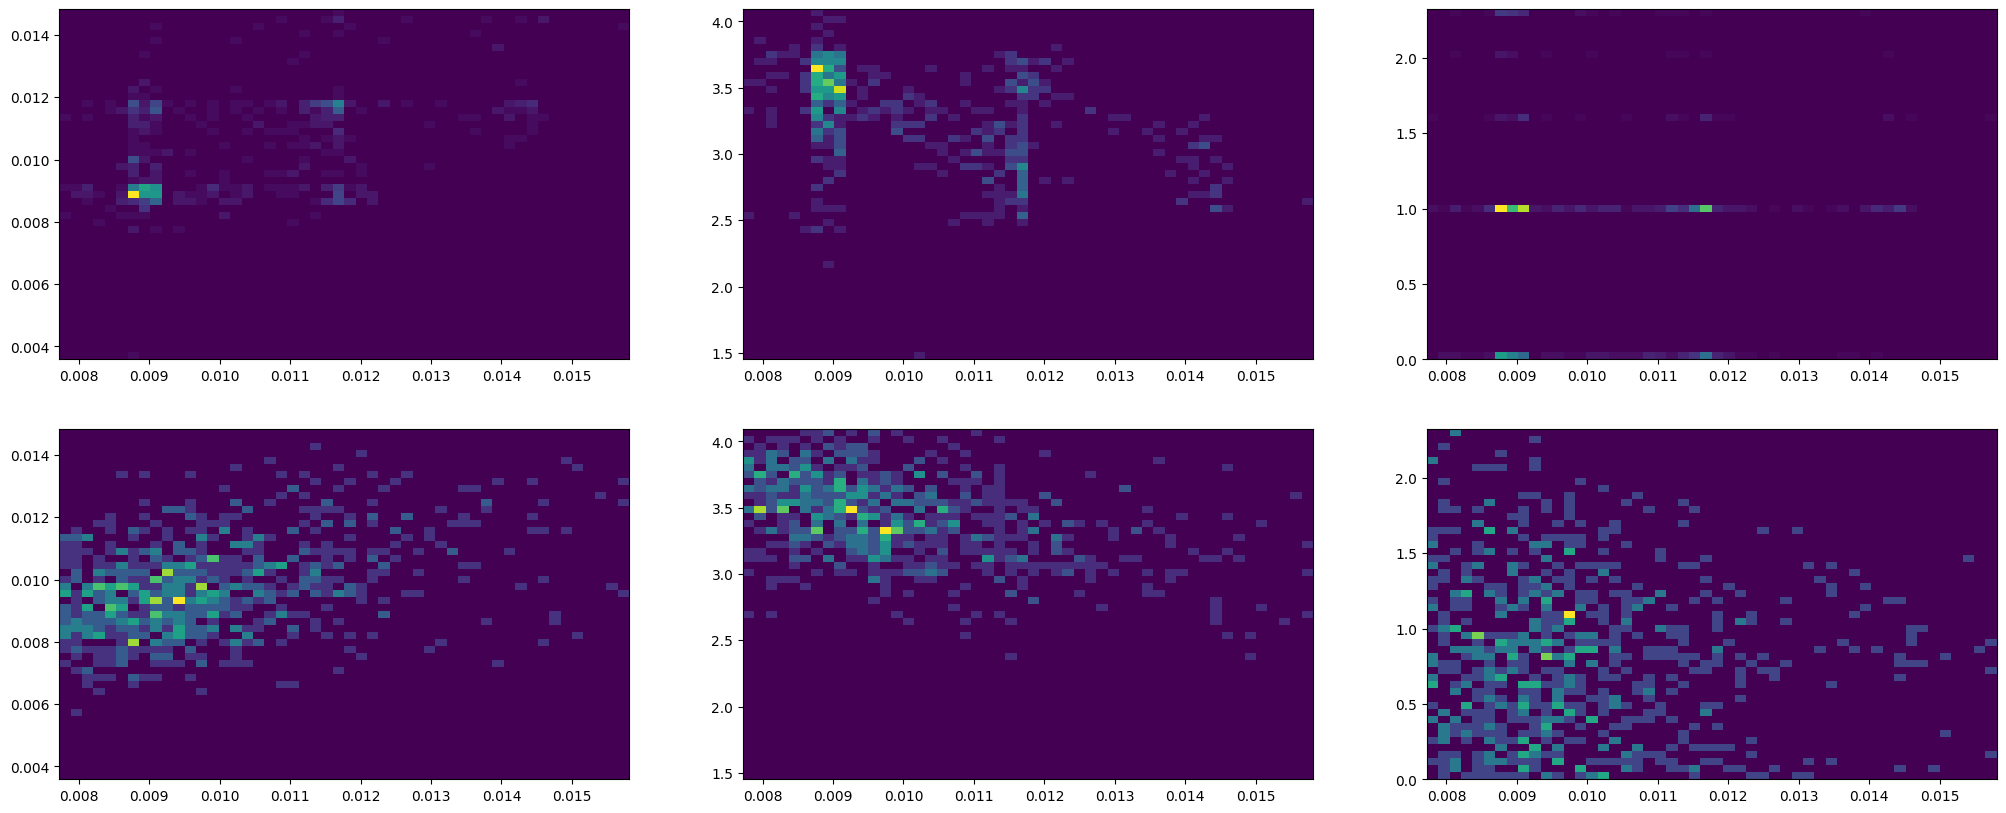

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

fig, axs = plt.subplots(2, 3, figsize=(25, 10))

ax = axs[0]
hist_settings = {'bins':50
}

ax[0].hist2d(*np.transpose(data_selected)[[0, 1]], **hist_settings)
ax[1].hist2d(*np.transpose(data_selected)[[0, 2]], **hist_settings)
ax[2].hist2d(*np.transpose(data_selected)[[0, 3]], **hist_settings)

ax = axs[1]
hist_settings = {'bins':100
}
data=imgs.detach().numpy()

for i in range(3):
  ax[i].hist2d(*np.transpose(data)[[0, i+1]], bins=(np.linspace(*axs[0][i].get_xlim(), 51), np.linspace(*axs[0][i].get_ylim(), 51)))

for i in range(3):
    axs[1][i].set_xlim(axs[0][i].get_xlim())
    axs[1][i].set_ylim(axs[0][i].get_ylim())

plt.show()
